In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# Copyright (c) 2022 Milan Ondrašovič <milan.ondrasovic@gmail.com>
#
# MIT License
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import config as cfg
from dataset import (
    load_dataset_and_extract_features, MultiClassLabelGetter
)
from visual import plot_linear_feature_importance

plt.style.use('dark_background')

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
quality_factors_bounds = [60, 70, 80, 90, 100]
label_names = ['best', 'very-low', 'low', 'medium', 'high', 'very-high']

label_getter = MultiClassLabelGetter(quality_factors_bounds)

In [3]:
features_train, labels_train = load_dataset_and_extract_features(
    cfg.TRAIN_DIR_PATH, label_getter
)
features_test, labels_test = load_dataset_and_extract_features(
    cfg.TEST_DIR_PATH, label_getter
)

features_train.shape, features_test.shape

100%|██████████| 174/174 [00:05<00:00, 30.45it/s]


((708, 192), (174, 192))

In [4]:
np.unique(labels_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([118, 118, 118, 118, 118, 118], dtype=int64))

In [5]:
model = LogisticRegression(
    max_iter=5000, multi_class='multinomial', random_state=731995
)
pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('model', model)
    ],
    verbose=True
)

pipeline.fit(features_train, labels_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.4s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(max_iter=5000, multi_class='multinomial',
                                    random_state=731995))],
         verbose=True)

In [6]:
labels_pred = pipeline.predict(features_test)
print(classification_report(labels_test, labels_pred, target_names=label_names))

              precision    recall  f1-score   support

        best       1.00      0.97      0.98        29
    very-low       0.70      0.79      0.74        29
         low       0.51      0.66      0.58        29
      medium       0.35      0.21      0.26        29
        high       0.45      0.45      0.45        29
   very-high       0.43      0.45      0.44        29

    accuracy                           0.59       174
   macro avg       0.57      0.59      0.57       174
weighted avg       0.57      0.59      0.57       174



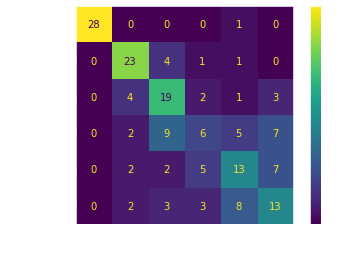

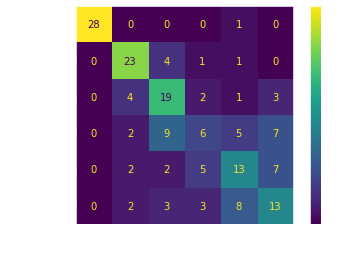

In [7]:
disp = ConfusionMatrixDisplay.from_predictions(
    labels_test, labels_pred, display_labels=label_names
)
disp.plot()
plt.savefig('CM_multi_linear_classifier.png', dpi=200)

E:\venvs\siam-mot\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


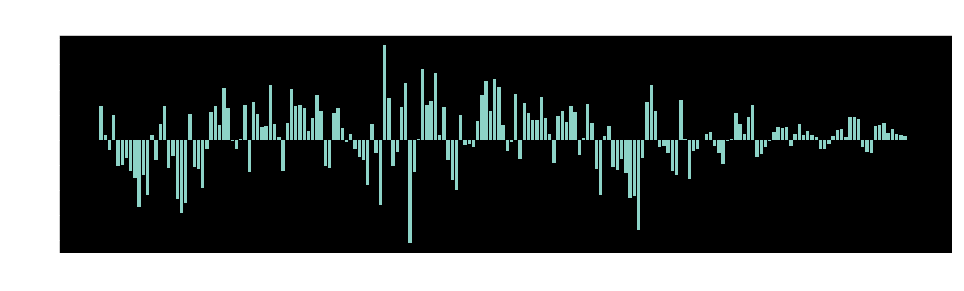

In [8]:
fig = plot_linear_feature_importance(model)
fig.show()

In [9]:
def calc_reduced_features(features, *, n_components=2, n_iter=3000):
    tsne = TSNE(
        n_components=n_components, n_iter=n_iter, metric='euclidean'
    )
    reduced_features = tsne.fit_transform(features)
    
    return reduced_features

reduced_features = calc_reduced_features(features_train)
reduced_features.shape

E:\venvs\siam-mot\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
E:\venvs\siam-mot\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(708, 2)

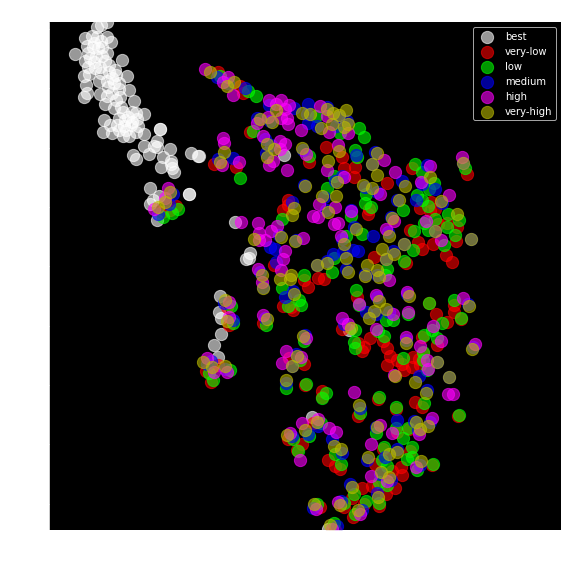

In [10]:
class_colors = [
    '#ffffff',  # white
    '#ff0000',  # red
    '#00ff00',  # green
    '#0000ff',  # blue
    '#ff00ff',  # magenta
    '#bbbb00',  # yellow
    '#00ffff',  # cyan
    '#964b00',  # brown
    '#ffa500',  # orange
    '#30d5c8',  # turquoise
    '#bc8f8f',  # rosy brown
    '#d4a437',  # gold
    '#3cb371',  # medium sea green
]

color_seq = [
    class_colors[label % len(class_colors)] for label in labels_train
]

fig, ax = plt.subplots(figsize=(8, 8))
xs = reduced_features[:, 0]
ys = reduced_features[:, 1]

for label_idx in np.unique(labels_train):
    label_name = label_names[label_idx]

    selector = labels_train == label_idx
    curr_xs = xs[selector]
    curr_ys = ys[selector]

    color = class_colors[label_idx % len(class_colors)]
    ax.scatter(
        curr_xs, curr_ys, alpha=0.6, s=150, c=color, antialiased=True,
        label=label_name
    )

ax.legend(loc='best')

min_coord = np.min(reduced_features)
max_coord = np.max(reduced_features)
ax_lims = (min_coord, max_coord)

ax.set_title("Feature Embedding t-SNE Visualization")
ax.set_xlabel("X coordinate (first component)")
ax.set_ylabel("Y coordinate (second component)")
ax.set_xlim(ax_lims)
ax.set_ylim(ax_lims)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig('features_tSNE.png', dpi=200)